## CODE FOR DRAFT TO RUN (NO NEED TO COPY IT)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

import json

FOLDER_PATH = 'data/'
DATA_COLUMNS = ['wiki_movie_id', 'freebase_movie_id', 'movie_name',
       'movie_box_office_revenue', 'movie_runtime', 'languages', 'countries',
       'genres', 'imdb_id', 'cast', 'rating', 'votes', 'budget', 'plot',
       'characters_names', 'main_character', 'release_year']
df = pd.read_csv(FOLDER_PATH + 'movie_processed.csv', names=DATA_COLUMNS, header=0, index_col=0)
df.head()
df_r1 = df[df["release_year"].notna()]

## CODE TO KEEP

In [31]:
###### add to the imports if not already done
import matplotlib.pyplot as plt
#########


def currency(x, pos):
    if x >= 1e6:
        s = '${:1.0f}M'.format(x*1e-6)
    elif x > 0:
        s = '${:1.0f}K'.format(x*1e-3)
    else:
        s = '${:1.0f}'.format(x)
    return s

### FOR CHARACTER TYPE

/tmp/ipykernel_73325/1853302654.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax.bar(df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False).index[0:30], df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False)[0:30]["movie_box_office_revenue"], label="Mean box office revenue")
/tmp/ipykernel_73325/1853302654.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_73325/1853302654.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


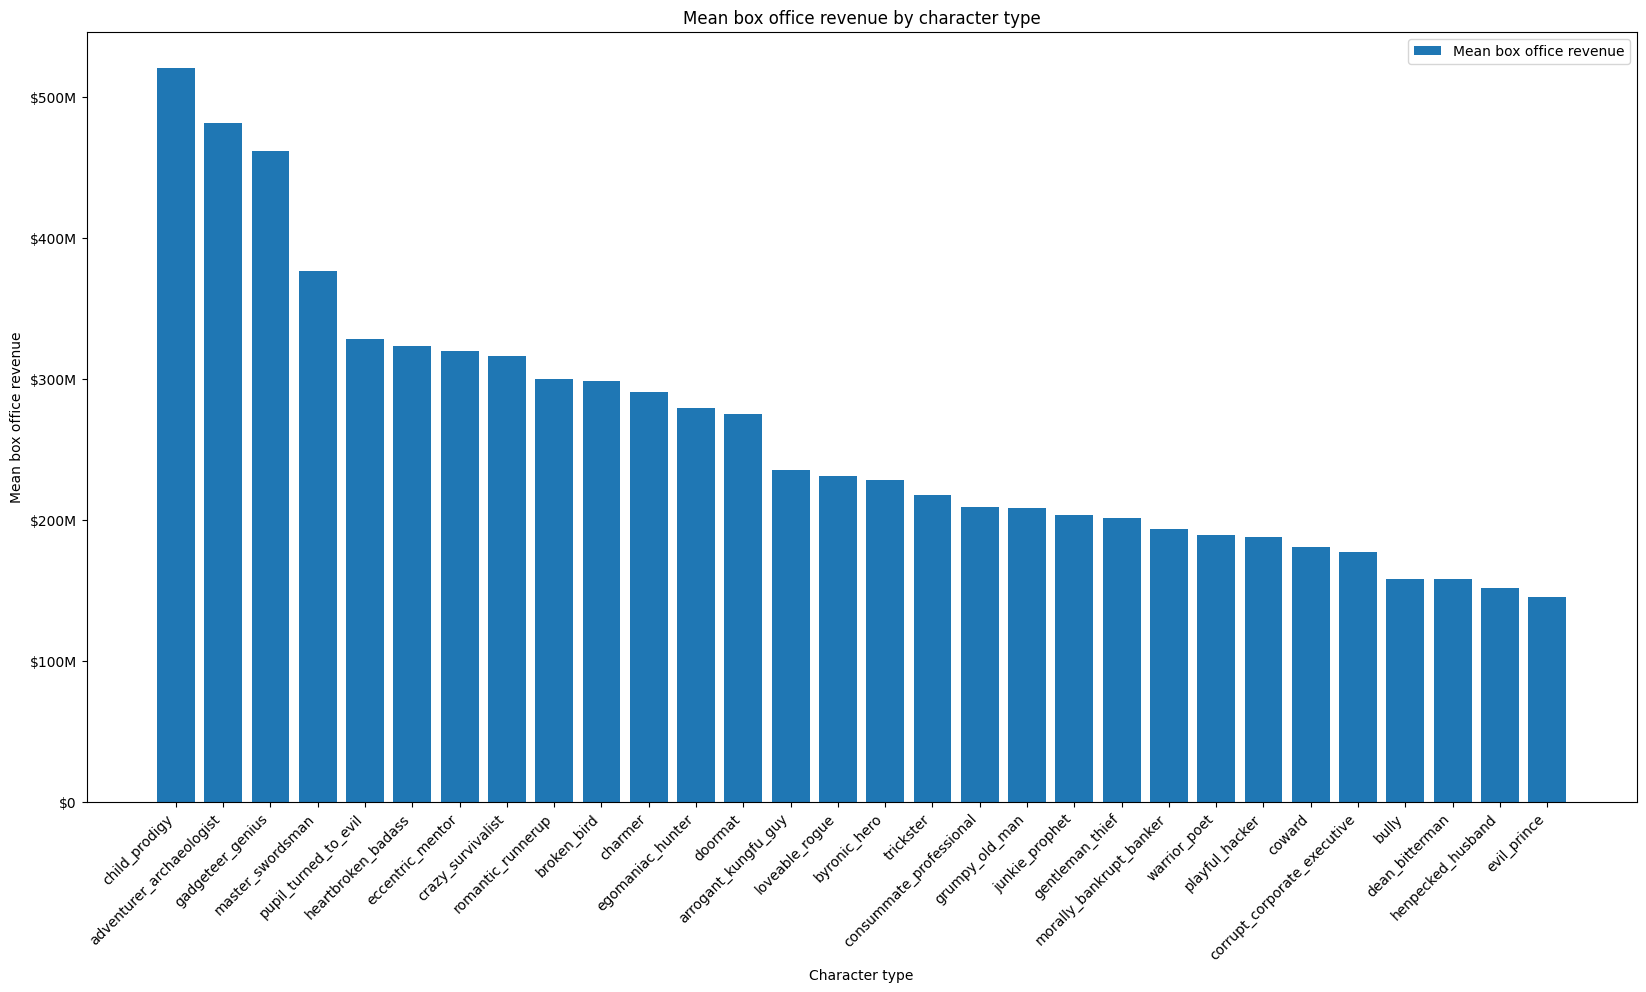

In [50]:

################################################## STUFF TO DO IN PREPOCESSING #############################
COLOMNS_NAMES_TV_TROPES = [
    "character_type",
    "object"
]
df_tvtropes = pd.read_csv(FOLDER_PATH + 'tvtropes.clusters.txt', sep='\t', header=None, names=COLOMNS_NAMES_TV_TROPES)

# Treats the object column to turn it into multiple columns
df_tvtropes["character_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["char"], axis=1)
df_tvtropes["movie_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["movie"], axis=1)
df_tvtropes["freebase_id"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["id"], axis=1)
df_tvtropes["actor_name"] = df_tvtropes.apply(lambda x: json.loads(x["object"])["actor"], axis=1)
df_tvtropes.drop("object", axis=1, inplace=True)

df_tvtropes.head()

################################################## STUFF TO ADD IN R1 ############################################

# We remove the movies with no box office value (removed 27030 movies) 34617-7587=27030
df_box_office = df[df["movie_box_office_revenue"].notna()]
df_character_type = df_tvtropes.copy()

# We add the box office revenue for each movie in the character type dataframe
df_character_type["movie_box_office_revenue"] = df_character_type["movie_name"].apply(lambda movie_name: df_box_office[df_box_office["movie_name"] == movie_name]["movie_box_office_revenue"].values)
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else 0)
#TODO: drop movies with 0 as box office_revenue

# We group the dataframe by character type and take the mean of the box office revenue
df_character_type = df_character_type.groupby("character_type")


# We plot the mean box office revenue by character type for the 30 character types with the highest mean box office revenue
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False).index[0:30], df_character_type.mean().sort_values("movie_box_office_revenue", ascending=False)[0:30]["movie_box_office_revenue"], label="Mean box office revenue")
ax.set_xlabel("Character type")
ax.set_ylabel("Mean box office revenue")
ax.set_title("Mean box office revenue by character type")
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(currency)
fig.savefig("mean_box_office_revenue_by_character_type.png")
fig.show()



### FOR BOX OFFICE EVOLUTION (25%, 50%, 75%)

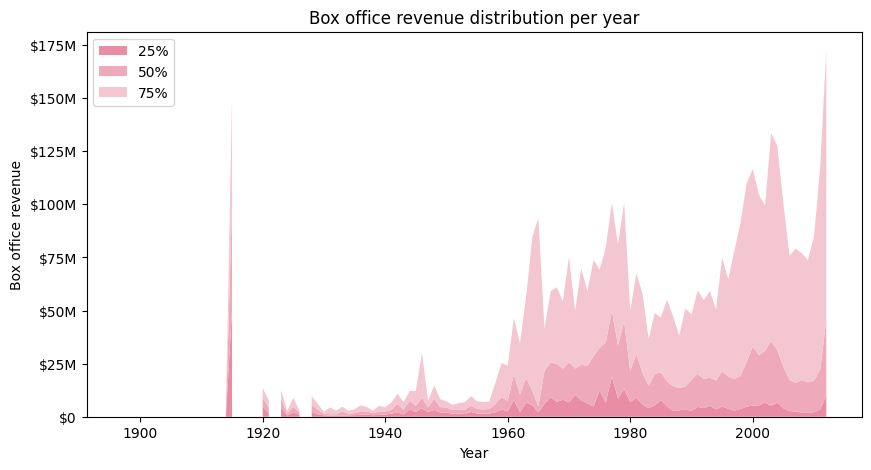

In [51]:



stats = df_r1[["release_year", "movie_box_office_revenue"]].groupby("release_year").describe()
a = stats.movie_box_office_revenue["25%"]
b = stats.movie_box_office_revenue["50%"]
c = stats.movie_box_office_revenue["75%"]



fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(stats.index, a, b, c, labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()


In [ ]:
df_r1[df_r1.release_year <= 1920].sort_values(by="movie_box_office_revenue", ascending=False)[["movie_name", "movie_box_office_revenue", "release_year"]].head(6)

Before 1920 we only have the box office value for 4 movies of which "The Birth of a Nation" and " Way Down East" which respectively had a box office of 50 million dollars and 4,5 million dollars. This explains the spike seen on the graph. Furtheron we will remove those movies even if the data is correct it is not relevant as we do not have enough data point for that period. 

## DRAFT STUFF

In [ ]:
df_character_type["movie_box_office_revenue"] = df_character_type["movie_box_office_revenue"].apply(lambda x: x[0] if len(x) > 0 else None) 
# import numpy as np
# df_character_type.groupby("character_type")
#.aggregate(np.mean)
# , "character_name", "movie_name", "freebase_id", "actor_name"
df_character_type.groupby("character_type").mean().sort_values("movie_box_office_revenue", ascending=False).plot(kind="bar", figsize=(20, 10))

In [ ]:

#### Runtime evolution
# Cleaning runtime data

# soldiers of freedom is indeed a 6h movie
# Unsung heroes is actually 98 min long
# Swallow the sun is a TV series so indeed really long...
# heimat est une serie de films...
# once a eagle is a mini serie
df_r1.sort_values("movie_runtime", ascending=False)[["movie_name", "movie_runtime"]].head(30)

# Remove outliers
# We remove movies with a runtime higher than 6h as it corresponds mostly to TV series, mini series and errors (removed 20 movies)
df_runtime = df_r1[df_r1["movie_runtime"] < 450]
def group_by_decade(df):
    df["decade"] = df["release_year"].apply(lambda x: int(x/10)*10)
    return df

df_runtime.boxplot(column="movie_runtime", by="release_year", figsize=(20, 10))

df_runtime_decade = group_by_decade(df_runtime)
df_runtime_decade.boxplot(column="movie_runtime", by="decade", figsize=(20, 10))


# We remove the movies without value for the box office (26830 movies removed, 7461 kept)
df_runtime = df_runtime[df_runtime["movie_box_office_revenue"].notna()] 
#df_runtime.boxplot(column="movie_runtime", by="movie_box_office_revenue", figsize=(20, 10))

#df_runtime.sort_values("movie_box_office_revenue", ascending=False)[["movie_name", "movie_runtime", "movie_box_office_revenue"]].head(50)

def group_by_thousand(df):
    df["thousand"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000)*1000)
    return df

def group_by_million(df):
    df["million"] = df["movie_box_office_revenue"].apply(lambda x: int(x/1000000)*1000000)
    return df

#df_runtime_thousand = group_by_thousand(df_runtime)
#df_runtime_thousand.boxplot(column="movie_runtime", by="thousand", figsize=(20, 10))

df_runtime_million = group_by_million(df_runtime)
#df_runtime_million.boxplot(column="movie_runtime", by="million", figsize=(20, 10))


# box_offices = df_runtime_million.movie_box_office_revenue.apply(lambda x: int(x/1000000)*1000000).value_counts()
# fig, ax = plt.subplots()
# ax.bar(box_offices.index, box_offices.values, color="blue")
# ax.set_xlabel("Box office")
# ax.set_ylabel("Number of movies")
# ax.set_title("Movie box office")
# plt.xticks(rotation=90)
# plt.show()
# box_offices

#### Number of character evolution
# Clean cast data
# We remove the movies with no cast (removed 17703 movies)
df_cast = df_r1[df_r1["cast"].notna()]
df_cast["cast_length"] = df_cast["cast"].apply(lambda cast: len(cast))
#df_cast.boxplot(column="cast_length", by="release_year", figsize=(20, 10))
type(df_cast["cast"].head(1).values[0])

#### Ratio Men/Women evolution
# TODO: try to do a graph nb of women in cast by year (or by decade) and another one with nb of men
def get_nb_actors(cast):
    return len(cast)

def get_nb_female_actors(cast):
    return None
